In [13]:
# Importing required libraries
import pickle
import nltk
import pandas as pd

# preprocessing dependencies
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# model dependencies
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.metrics import Precision, Recall

# plot dependencies
import matplotlib.pyplot as plt
import wordcloud

In [14]:
# load dataset
twitter = pd.read_csv('Twitter_Data.csv')
twitter.head()
data_v1 = twitter

In [15]:
# check the distribution of values
twitter['category'].value_counts()

 1.0    72250
 0.0    55213
-1.0    35510
Name: category, dtype: int64

In [16]:
# clean NaN values
print(twitter.isna().sum())
# drop NaN balues
df = twitter.dropna()

clean_text    4
category      7
dtype: int64


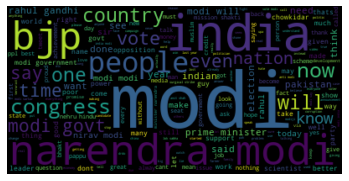

In [17]:
# check common words with the word cloud
common_words=''
for i in data_v1.clean_text:  
    i = str(i)
    tokens = i.split()
    common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [18]:
# clean dataset
def cleaning(df, stop_words):
    df['clean_text'] = df['clean_text'].apply(lambda x:' '.join(x.lower() for x in str(x).split()))
    # Replacing the digits/numbers
    df['clean_text'] = df['clean_text'].str.replace('^\d+\s|\s\d+\s|\s\d+$', '', regex = True)
    # Removing stop words
    df['clean_text'] = df['clean_text'].apply(lambda x:' '.join(x for x in x.split() if x not in stop_words))
    # Lemmatization
    df['clean_text'] = df['clean_text'].apply(lambda x:' '.join([Word(x).lemmatize() for x in str(x).split()]))
    return df

stop_words = stopwords.words('english')
data_v1 = cleaning(data_v1, stop_words)
data_v1.head()

,clean_text,category
0,modi promised “minimum government maximum gove...,-1.0
1,talk nonsense continue drama vote modi,0.0
2,say vote modi welcome bjp told rahul main camp...,1.0
3,asking supporter prefix chowkidar name modi gr...,1.0
4,answer among powerful world leader today trump...,1.0


In [19]:
# Encoded the target column
lb = LabelEncoder()
data_v1['category'] = lb.fit_transform(data_v1['category'])
data_v1.head()

,clean_text,category
0,modi promised “minimum government maximum gove...,0
1,talk nonsense continue drama vote modi,1
2,say vote modi welcome bjp told rahul main camp...,2
3,asking supporter prefix chowkidar name modi gr...,2
4,answer among powerful world leader today trump...,2


In [20]:
# tokenize input text
tokenizer = Tokenizer(num_words=500, split=' ') 
tokenizer.fit_on_texts(data_v1['clean_text'].values)
X = tokenizer.texts_to_sequences(data_v1['clean_text'].values)
X = pad_sequences(X)

In [21]:
# saving tokenizer
with open('tokenizer_LSTM_twitter.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)

In [22]:
# Splitting the data into training and testing
y = pd.get_dummies(data_v1['category'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)

In [23]:
# create model achitecture
model = Sequential()
model.add(Embedding(500, 120, X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(4, activation = 'softmax'))
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy', Precision(), Recall()])
print(model.summary())

ValueError: Could not interpret initializer identifier: 35

In [ ]:
# run model 
batch_size = 32
history = model.fit(X_train, y_train, 
                    validation_data = (X_test, y_test),
                    epochs = 5, batch_size = batch_size, 
                    verbose = 'auto')

In [29]:
# Analyze the model using the test data
model.evaluate(X_test, y_test)

1528/1528 [==============================] - 30s 19ms/step - loss: 0.6652 - accuracy: 0.7261 - precision_1: 0.7737 - recall_1: 0.6713


[0.6651986241340637,
 0.7260808944702148,
 0.7737023234367371,
 0.6712889075279236]

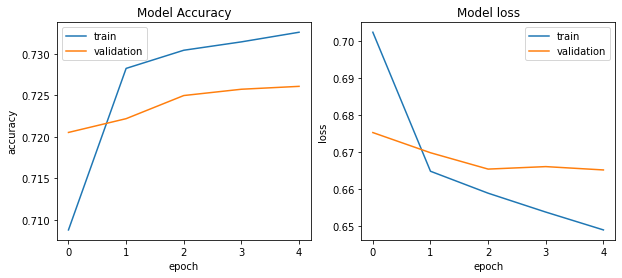

In [30]:
def plot_training_hist(history):
    '''Plot history for accuracy and loss'''
    fig, ax = plt.subplots(1, 2, figsize = (10, 4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc = 'best')
    #second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc = 'best')
    
plot_training_hist(history)

1528/1528 [==============================] - 30s 19ms/step


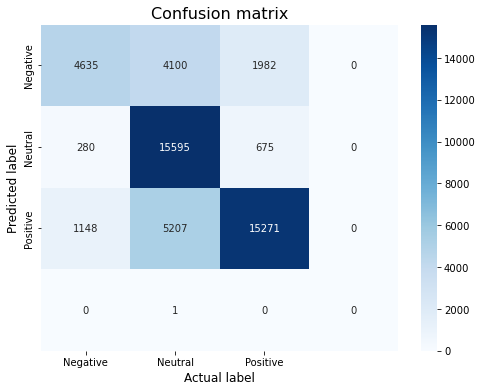

In [31]:
# check the model's performance on testing data
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use the model to do the prediction
    y_pred = model.predict(X_test)
    # compute the confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test), axis = 1), np.argmax(y_pred, axis = 1))
    # plot confusion matrix
    plt.figure(figsize = (8, 6))
    sns.heatmap(cm, cmap = plt.cm.Blues, annot = True, fmt = 'd',
                xticklabels = sentiment_classes,
                yticklabels = sentiment_classes)
    plt.title('Confusion matrix', fontsize = 16)
    plt.xlabel('Actual label', fontsize = 12)
    plt.ylabel('Predicted label', fontsize = 12)
    
plot_confusion_matrix(model, X_test, y_test)

In [32]:
# save model
model.save('model_LSTM_twitter.h5')